# Use extracted entities to evaluate the quality

- Not all the discipline are equal in terms of difficulty. A posteriori, choosing those that are more interesting for us.
- BLEU and ROUGE are not good metrics because of paraphrasing.
- Semantic similarity works well but cannot be enough. It is very easy for an LLM to generate similar content.
- **Creation of ontology-based methods**:
  - Run NER to input and output
  - For each mention, compute similarity [lexical or semantic] to the ones in target and rank
  - Get the most similar and calculate distance in ontology (see graph distances) and if it’s a parent or a child
- Error Typology
    - The closest one is a child of a non-matched input term 
    - Distance to input terms is higher than a given threshold
    - Doesn’t match with any. Repeated or irrelevant information.

- Few shot prompting (demasiado largo) con LLama
- Chain of thought: pedir las entidades, ...

In [1]:
import pandas as pd

path_orig = "output/data/ents_orig_scispacy.csv"
path_gen = "output/data/2step_transformation_dt4h_GPT4omini/en/ents_gen_scispacy.csv"
path_cm = "data/umls/cm_umls_sct_24.tsv"

# Load Datasets

In [2]:
df_umls_sct = pd.read_csv(path_cm, sep="\t", dtype=str)
print("UMLS to SCT mapping:\n", df_umls_sct.head().to_markdown(), "\n")


UMLS to SCT mapping:
 |    | code     |   sct_code |
|---:|:---------|-----------:|
|  0 | C0000039 |  102735002 |
|  1 | C0000052 |   58488005 |
|  2 | C0000097 |  285407008 |
|  3 | C0000102 |   13579002 |
|  4 | C0000163 |  112116001 | 



In [3]:
df_orig = pd.read_csv(path_orig, dtype=str)
df_orig["normalized"] = True
df_orig.loc[df_orig["code"].isnull(), "normalized"] = False
# df_orig = df_orig.merge(df_umls_sct, on="code", how="left")
print("Original:\n", df_orig.head().to_markdown(), "\n")

Original:
 |    |   filenameid | span                            | mention_class   | code     | term                       | normalized   |
|---:|-------------:|:--------------------------------|:----------------|:---------|:---------------------------|:-------------|
|  0 |   33175723_1 | Amyloid light-chain amyloidosis | DISEASE         | C0268381 | Primary amyloidosis        | True         |
|  1 |   33175723_1 | cardiac amyloidosis             | DISEASE         | C0268407 | Senile cardiac amyloidosis | True         |
|  2 |   33175723_1 | cardiomyopathy                  | DISEASE         | C0878544 | Cardiomyopathies           | True         |
|  3 |   33175723_1 | heart failure                   | DISEASE         | C0018801 | Heart failure              | True         |
|  4 |   33175723_1 | AL amyloidosis                  | DISEASE         | C0268381 | Primary amyloidosis        | True         | 



In [4]:

df_gen = pd.read_csv(path_gen, dtype=str)
df_gen["normalized"] = True
df_gen.loc[df_gen["code"].isnull(), "normalized"] = False
# df_gen = df_gen.merge(df_umls_sct, on="code", how="left")
# df_gen["sct_code"] = df_gen["sct_code"].fillna(0).astype(int).astype(str).apply(lambda x: None if x == "0" else x)
print("Generated:\n", df_gen.head().to_markdown(), "\n")


Generated:
 |    | filenameid                 | span                                           | mention_class   | code     | term                   | normalized   |
|---:|:---------------------------|:-----------------------------------------------|:----------------|:---------|:-----------------------|:-------------|
|  0 | 36951253_transformed_step1 | End-stage dilated non-ischaemic cardiomyopathy | DISEASE         | nan      | nan                    | False        |
|  1 | 36951253_transformed_step1 | myocarditis                                    | DISEASE         | C0027059 | Myocarditis            | True         |
|  2 | 36951253_transformed_step1 | sarcopenia                                     | DISEASE         | C0872084 | Sarcopenia             | True         |
|  3 | 36951253_transformed_step1 | cardiac cachexia                               | DISEASE         | C0562491 | Cardiac cachexia       | True         |
|  4 | 36951253_transformed_step1 | cardiorespiratory arrest    

In [5]:
df_orig["filled_term"] = df_orig["term"]
df_gen["filled_term"] = df_gen["term"]

df_orig.loc[df_orig["normalized"] == False, "filled_term"] = df_orig.loc[df_orig["normalized"] == False, "span"]
df_gen.loc[df_gen["normalized"] == False, "filled_term"] =  df_gen.loc[df_gen["normalized"] == False, "span"]

df_orig["filled_term"] = df_orig["filled_term"] + " (" + df_orig["mention_class"] + ")"
df_gen["filled_term"] = df_gen["filled_term"] + " (" + df_gen["mention_class"] + ")"

In [6]:
df_gen

,filenameid,span,mention_class,code,term,normalized,filled_term
0,36951253_transformed_step1,End-stage dilated non-ischaemic cardiomyopathy,DISEASE,NaN,NaN,False,End-stage dilated non-ischaemic cardiomyopathy...
1,36951253_transformed_step1,myocarditis,DISEASE,C0027059,Myocarditis,True,Myocarditis (DISEASE)
2,36951253_transformed_step1,sarcopenia,DISEASE,C0872084,Sarcopenia,True,Sarcopenia (DISEASE)
3,36951253_transformed_step1,cardiac cachexia,DISEASE,C0562491,Cardiac cachexia,True,Cardiac cachexia (DISEASE)
4,36951253_transformed_step1,cardiorespiratory arrest,DISEASE,C0600228,Cardiopulmonary Arrest,True,Cardiopulmonary Arrest (DISEASE)
...,...,...,...,...,...,...,...
25279,33045427_transformed_step1,cardiotropic infectious,DISEASE,NaN,NaN,False,cardiotropic infectious (DISEASE)
25280,33045427_transformed_step1,post-EMB,CHEMICAL,NaN,NaN,False,post-EMB (CHEMICAL)
25281,33045427_transformed_step1,CD45R0,CHEMICAL,C3891563,"CD45RO, human",True,"CD45RO, human (CHEMICAL)"
25282,33045427_transformed_step1,CD11a+,CHEMICAL,C0079091,CD11a Antigen,True,CD11a Antigen (CHEMICAL)


In [7]:
import numpy as np
filename = "36951253"
print("Original File: {filename}\n")

arr_ex_gen = df_gen[df_gen["filenameid"].str.startswith(filename)].filled_term.unique()
arr_ex_orig = df_orig[df_orig["filenameid"] == filename].filled_term.unique()

inter = np.intersect1d(arr_ex_orig, arr_ex_gen)
o_minus_g = np.setdiff1d(arr_ex_orig, arr_ex_gen)
g_minus_o = np.setdiff1d(arr_ex_gen, arr_ex_orig)

print("Original & Generated:\n", inter)
print()
print("Original - Generated:\n", o_minus_g)
print()
print("Generated - Original:\n", g_minus_o)

tp = len(inter)
fp = len(g_minus_o)
fn = len(o_minus_g)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")


Original File: {filename}

Original & Generated:
 ['Cardiac cachexia (DISEASE)' 'Cardiopulmonary Arrest (DISEASE)'
 'Cessation of life (DISEASE)' 'Embolism (DISEASE)' 'Hemorrhage (DISEASE)'
 'Myocarditis (DISEASE)' 'Sarcopenia (DISEASE)' 'Thrombus (DISEASE)'
 'Ventricular arrhythmia (DISEASE)' 'aortic occlusion (DISEASE)'
 'coagulation derangements (DISEASE)' 'norepinephrine (CHEMICAL)']

Original - Generated:
 ['Foramen Ovale, Patent (DISEASE)' 'Heart Atrium (CHEMICAL)'
 'Inferior vena cava structure (DISEASE)'
 'Latex Fixation Tests (CHEMICAL)'
 'Musculoskeletal torsion, function (DISEASE)' 'Neoplasms (DISEASE)'
 'Pulmonary Edema (DISEASE)' 'Right ventricular failure (DISEASE)'
 'Stenosis Morphology (DISEASE)' 'Steroids (CHEMICAL)'
 'Syndrome (DISEASE)' 'Ventricular Dysfunction (DISEASE)'
 'acute dysfunction of the device (DISEASE)'
 'auricular wall bleeding (DISEASE)' 'cardioembolic (DISEASE)'
 'end-stage dilated non-ischaemic cardiomyopathy (DISEASE)'
 'heparin (CHEMICAL)' 'methylp

In [8]:
def get_class_metrics(tp, fp, fn):
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    return precision, recall, f1

def evaluate_files(file):
    arr_ex_orig = df_orig[df_orig["filenameid"] == file].filled_term.unique()
    arr_ex_gen = df_gen[df_gen["filenameid"].str.startswith(file)].filled_term.unique()

    try:
        inter = np.intersect1d(arr_ex_orig, arr_ex_gen)
        o_minus_g = np.setdiff1d(arr_ex_orig, arr_ex_gen)
        g_minus_o = np.setdiff1d(arr_ex_gen, arr_ex_orig)
    except Exception as e:
        print(e)
        print(arr_ex_orig)
        print(arr_ex_gen)

    tp = len(inter)
    fp = len(g_minus_o)
    fn = len(o_minus_g)
    tn = 0
    
    precision, recall, f1 = get_class_metrics(tp, fp, fn)

    return precision, recall, f1, tp, fp, fn

df_metrics = pd.DataFrame(columns=["filename", "precision", "recall", "f1", "tp", "fp", "fn"])
for filename in df_orig.filenameid.unique():
    precision, recall, f1, tp, fp, fn = evaluate_files(filename)
    df_i = pd.DataFrame([[filename, precision, recall, f1, tp, fp, fn]], columns=["filename", "precision", "recall", "f1", "tp", "fp", "fn"])
    df_metrics = pd.concat([df_metrics, df_i])
    
print(df_metrics)

/scratch/tmp/ipykernel_508662/3895690415.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, df_i])


      filename  precision    recall        f1  tp fp  fn
0   33175723_1   1.000000  1.000000  0.999999  15  0   0
0     36305455   0.863636  0.760000  0.808510  19  3   6
0     31668014   1.000000  0.607143  0.755555  17  0  11
0     32153696   0.818182  0.750000  0.782608   9  2   3
0     32470561   0.500000  0.666667  0.571428   4  4   2
..         ...        ...       ...       ...  .. ..  ..
0     29479047   0.806452  0.781250  0.793650  25  6   7
0     37710981   0.714286  0.833333  0.769230   5  2   1
0     28614216   0.896552  0.490566  0.634146  26  3  27
0     28232375   0.923077  0.631579  0.749999  12  1   7
0     37861254   0.833333  0.806452  0.819672  25  5   6

[1000 rows x 7 columns]


In [9]:
df_metrics.sort_values(["fp", "f1"], ascending=[False, True]).head(3)

,filename,precision,recall,f1,tp,fp,fn
0,33857916,0.636364,0.375000,0.471910,21,12,35
0,32997782,0.666667,0.392857,0.494382,22,11,34
0,31974261,0.725000,0.391892,0.508771,29,11,45


In [10]:
df_metrics.sort_values(["fn", "f1"], ascending=[False, True]).head(3)

,filename,precision,recall,f1,tp,fp,fn
0,30785587,0.800000,0.222222,0.347826,20,5,70
0,31378248,1.000000,0.323232,0.488549,32,0,67
0,33544806,0.891892,0.366667,0.519685,33,4,57


In [11]:
seed = 42
df_metrics.sample(3, random_state=seed)

,filename,precision,recall,f1,tp,fp,fn
0,35249914,0.733333,0.343750,0.468085,11,4,21
0,34530632,0.736842,0.736842,0.736842,14,5,5
0,31802469,0.724138,0.913043,0.807692,21,8,2


In [12]:
d_macro = df_metrics[["precision", "recall", "f1", "tp", "fp", "fn"]].mean().to_dict()
d_macro

{'precision': 0.8232126228426311,
 'recall': 0.7156443701418516,
 'f1': 0.7535634795146179,
 'tp': 16.569,
 'fp': 3.245,
 'fn': 8.345}

In [13]:
micro_precision, micro_recall, micro_f1 = get_class_metrics(*df_metrics[["tp", "fp", "fn"]].sum().values)


print(f"Micro Precision: {micro_precision:.2f}")
print(f"Micro Recall: {micro_recall:.2f}")
print(f"Micro F1: {micro_f1:.2f}")
print()
print(f"Macro Precision: {d_macro['precision']:.2f}")
print(f"Macro Recall: {d_macro['recall']:.2f}")
print(f"Macro F1: {d_macro['f1']:.2f}")


Micro Precision: 0.84
Micro Recall: 0.67
Micro F1: 0.74

Macro Precision: 0.82
Macro Recall: 0.72
Macro F1: 0.75


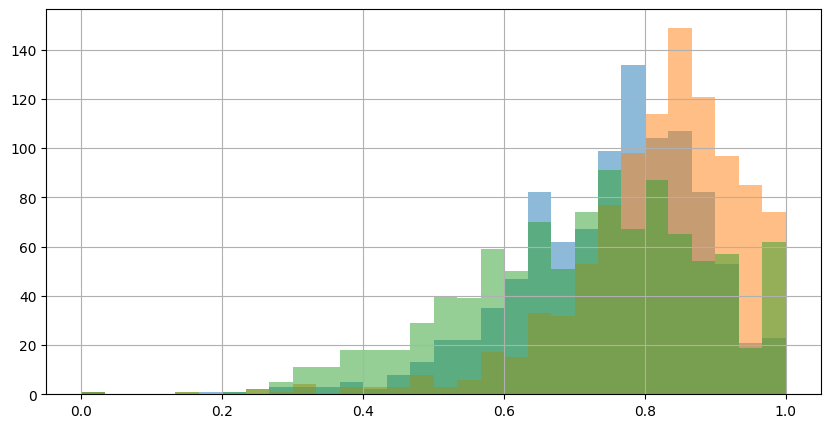

In [14]:
df_metrics["f1"].hist(bins=30, figsize=(10, 5), alpha=0.5);
df_metrics["precision"].hist(bins=30, figsize=(10, 5), alpha=0.5);
df_metrics["recall"].hist(bins=30, figsize=(10, 5), alpha=0.5);

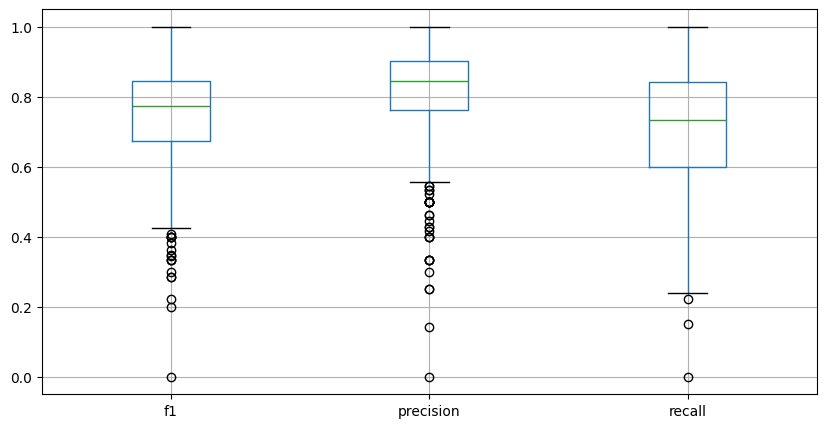

In [15]:
df_metrics.boxplot(column=["f1", "precision", "recall"], figsize=(10, 5));

# Check the amount of normalized entities

Text(0.5, 1.0, 'Generated')

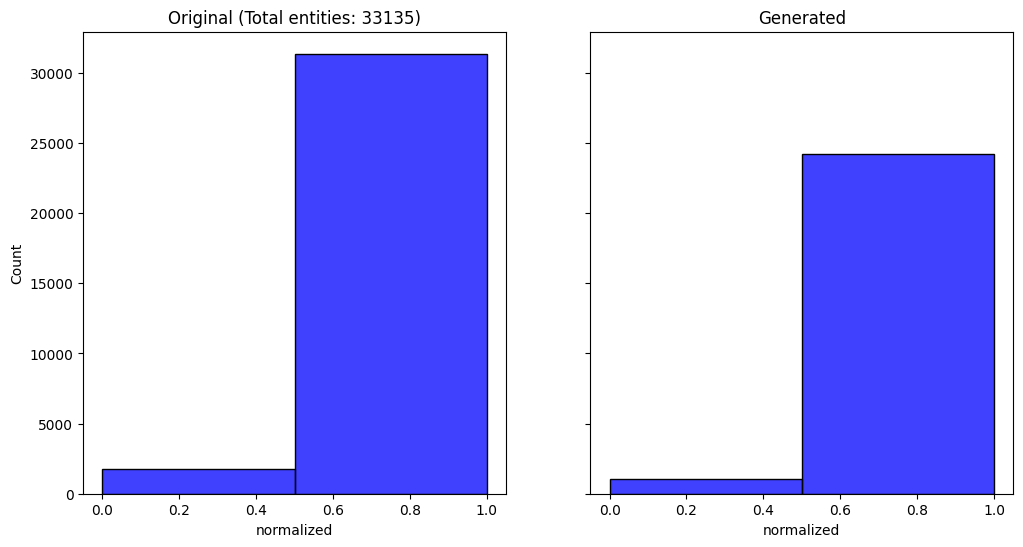

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.histplot(df_orig["normalized"], bins=2, kde=False, color="blue", label="Original", ax=ax[0])
ax[0].set_title("Original (Total entities: {})".format(len(df_orig)))

sns.histplot(df_gen["normalized"], bins=2, kde=False, color="blue", label="Original", ax=ax[1])
ax[1].set_title("Generated")


In [17]:
print("Original:\n\n", df_orig["normalized"].value_counts(), "\n\n")
print("Generated:\n\n", df_gen["normalized"].value_counts())

Original:

 normalized
True     31356
False     1779
Name: count, dtype: int64 


Generated:

 normalized
True     24231
False     1053
Name: count, dtype: int64


In [18]:
df_umls_sct = pd.read_csv(path_cm, sep="\t")
df_umls_sct 

,code,sct_code
0,C0000039,102735002
1,C0000052,58488005
2,C0000097,285407008
3,C0000102,13579002
4,C0000163,112116001
...,...,...
547562,C5942196,851321000124104
547563,C5942197,851331000124101
547564,C5942198,861171000124107
547565,C5942199,6011000124106


In [19]:
df_orig_sct = df_orig.merge(df_umls_sct, on="code", how="left")

In [20]:
df_orig_sct[df_orig_sct["sct_code"].isnull()&df_orig_sct["normalized"]].shape

(2060, 8)

# Sample selection

In [34]:
import os
phase1_files = [x.split("_")[0] for x in os.listdir("data/human_eval/gpt4omini") if x.endswith(".txt")]
print("Phase 1 Files:\n", phase1_files)

Phase 1 Files:
 ['32997782', '34530632', '30785587', '31378248', '33857916']


Not all of the samples can be manually annotated. We will select a subset of the samples to be annotated.

For this, we want to have a represenative samples in terms of the scores provided by the automatic evaluation system.

Following the idea of [k-means sampling](https://info.ornl.gov/sites/publications/files/Pub32719.pdf), we will use precision and recall with K-means to select the samples. We set the number of clusters to the number of samples we want to select.

Phase 1: ['32997782.txt', '34530632.txt', '30785587.txt', '31378248.txt', '33857916.txt']

In [39]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_metrics_p2 = df_metrics[~df_metrics["filename"].isin(phase1_files)]

assert len(df_metrics_p2) == len(df_metrics) - len(phase1_files)

# Assuming `df` is your dataframe
# Normalize the metrics
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(df_metrics_p2[['precision', 'recall']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=30, random_state=42)
df_metrics_p2.loc[:, 'cluster'] = kmeans.fit_predict(normalized_metrics)

# Sample one row from each cluster
sampled_df = df_metrics_p2.groupby('cluster').apply(lambda x: x.sample(1, random_state=42), include_groups=False).reset_index(drop=True)


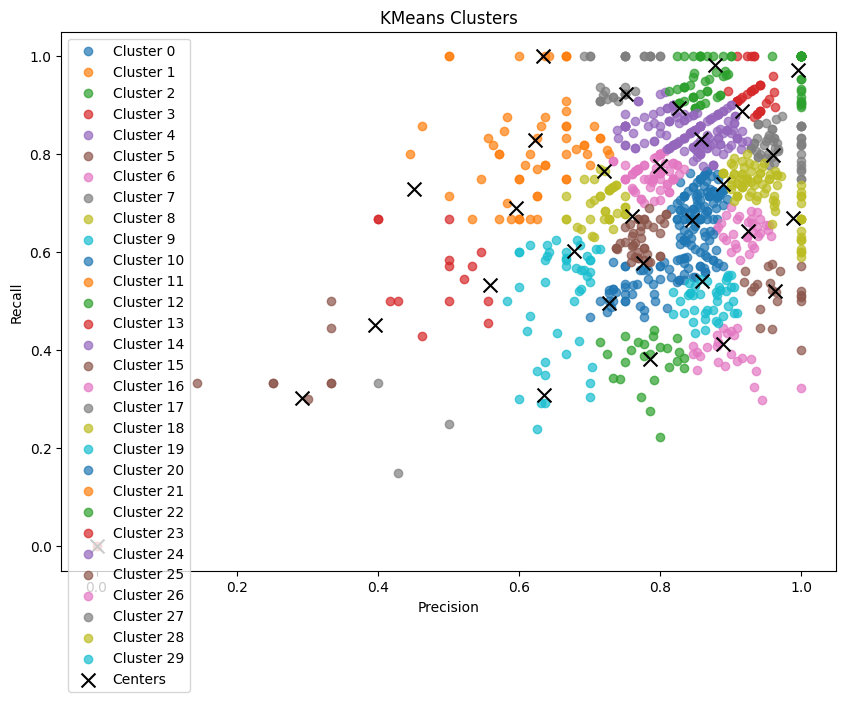

In [40]:

# Plot the clusters
plt.figure(figsize=(10, 7))
for cluster in range(kmeans.n_clusters):
    cluster_data = df_metrics[df_metrics['cluster'] == cluster]
    plt.scatter(
        cluster_data['precision'],
        cluster_data['recall'],
        label=f'Cluster {cluster}',
        alpha=0.7
    )

# Highlight cluster centers
cluster_centers = kmeans.cluster_centers_
# Inverse transform centers back to original scale
cluster_centers_original = scaler.inverse_transform(cluster_centers)
plt.scatter(
    cluster_centers_original[:, 0],  # Precision
    cluster_centers_original[:, 1],  # Recall
    color='black',
    label='Centers',
    marker='x',
    s=100
)

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('KMeans Clusters')
plt.legend()
plt.show()

In [41]:
sampled_df

,filename,precision,recall,f1,tp,fp,fn
0,32153696,0.818182,0.750000,0.782608,9,2,3
1,32111713,0.823529,0.424242,0.560000,28,6,38
2,31912911_1,0.500000,0.583333,0.538461,7,7,5
3,34962277,1.000000,0.736842,0.848484,14,0,5
4,34118375,0.950000,0.730769,0.826086,19,1,7
5,30072860_2,0.666667,0.909091,0.769230,10,5,1
6,31512669,0.888889,0.960000,0.923076,24,3,1
7,31204375,0.333333,0.444444,0.380952,4,8,5
8,31486515,0.827586,0.685714,0.749999,24,5,11
9,36750509_2,0.666667,0.666667,0.666666,6,3,3


In [44]:
df_metrics_p1 = df_metrics[df_metrics["filename"].isin(phase1_files)]
df_metrics_p1

,filename,precision,recall,f1,tp,fp,fn,cluster
0,32997782,0.666667,0.392857,0.494382,22,11,34,9
0,31378248,1.000000,0.323232,0.488549,32,0,67,26
0,33857916,0.636364,0.375000,0.471910,21,12,35,9
0,34530632,0.736842,0.736842,0.736842,14,5,5,8
0,30785587,0.800000,0.222222,0.347826,20,5,70,2


In [43]:
sampled_df.to_csv("output/samples/phase_2.csv", index=False)

In [45]:
df_metrics_p1.to_csv("output/samples/phase_1.csv", index=False)

In [52]:
p1_path_orig = [f"data/1_original/txt/{x}.txt" for x in df_metrics_p1.filename.unique()]
p1_path_gen = [f"data/2_generated/2step_transformation_dt4h_GPT4omini/en/{x}_transformed_step1.txt" for x in df_metrics_p1.filename.unique()]

p2_path_orig = [f"data/1_original/txt/{x}.txt" for x in sampled_df.filename.unique()]
p2_path_gen = [f"data/2_generated/2step_transformation_dt4h_GPT4omini/en/{x}_transformed_step1.txt" for x in sampled_df.filename.unique()]


In [ ]:
# import shutil
# import os

# def copy_files(paths, dest):
#     if not os.path.exists(dest):
#         os.makedirs(dest)
        
#     for p in paths:
#         shutil.copy(p, dest)
#         print(f"Copying {p} to {dest}")
            
# copy_files(p1_path_orig, "output/samples/en/phase_1/original/")
# copy_files(p1_path_gen, "output/samples/en/phase_1/generated/")

# copy_files(p2_path_orig, "output/samples/en/phase_2/original/")
# copy_files(p2_path_gen, "output/samples/en/phase_2/generated/")


Copying data/1_original/txt/32997782.txt to output/samples/en/phase_1/original/
Copying data/1_original/txt/31378248.txt to output/samples/en/phase_1/original/
Copying data/1_original/txt/33857916.txt to output/samples/en/phase_1/original/
Copying data/1_original/txt/34530632.txt to output/samples/en/phase_1/original/
Copying data/1_original/txt/30785587.txt to output/samples/en/phase_1/original/
Copying data/2_generated/2step_transformation_dt4h_GPT4omini/en/32997782_transformed_step1.txt to output/samples/en/phase_1/generated/
Copying data/2_generated/2step_transformation_dt4h_GPT4omini/en/31378248_transformed_step1.txt to output/samples/en/phase_1/generated/
Copying data/2_generated/2step_transformation_dt4h_GPT4omini/en/33857916_transformed_step1.txt to output/samples/en/phase_1/generated/
Copying data/2_generated/2step_transformation_dt4h_GPT4omini/en/34530632_transformed_step1.txt to output/samples/en/phase_1/generated/
Copying data/2_generated/2step_transformation_dt4h_GPT4omini